# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, recall
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [82]:
data = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_2_implicit/webinar_2 2/retail_train.csv')
item_features = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_2_implicit/webinar_2 2/product.csv')
user_features = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_2_implicit/webinar_2 2/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [83]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [84]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [85]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 1046545, 844179, 1106523]

In [86]:
recommender.get_own_recommendations(2375, N=5)

[847962, 918046, 873980, 872062, 884694]

In [87]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 9836106, 1044078, 842125, 893018]

In [88]:
recommender.get_similar_users_recommendation(2375, N=5)

[935578, 949023, 1037135, 12731544, 993430]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [366]:
common_users = data_train_lvl_1.user_id.values

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]


In [90]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [91]:
%%time

k = 50

result_lvl_1['candidates_own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
result_lvl_1['candidates_sim_item'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=k))
result_lvl_1['candidates_als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=k))

CPU times: user 46.3 s, sys: 4.78 s, total: 51.1 s
Wall time: 15.4 s


In [92]:
# %%time
# result_lvl_1['candidates_sim_user'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=k))

In [93]:
result_lvl_1.head(2)

,user_id,actual,candidates_own,candidates_sim_item,candidates_als,candidates_sim_user
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[896666, 856942, 877391, 5577022, 1088462, 888...","[13876352, 1007512, 936685, 1097909, 1109680, ...","[995598, 1097909, 883616, 901067, 6979526, 106...","[9420183, 1046562, 1042571, 1131321, 901067, 9..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[932631, 1107760, 911974, 1076580, 947427, 102...","[9836106, 8090537, 5569845, 1007512, 9553042, ...","[5569230, 1021324, 1082627, 1075368, 12172240,...","[8090653, 1125601, 1133654, 5571176, 1057168, ..."


In [160]:
def recall_calc(data, top_k):
    for col in data.columns[2:]:      
        yield col, data.apply(lambda row: recall_at_k(row[col], row['actual'], k=top_k), axis=1).mean()

In [171]:
sorted(recall_calc(result_lvl_1, 50), key=lambda x: x[1], reverse=True)

[('candidates_own', 0.0675325596656315),
 ('candidates_als', 0.04823866200586155),
 ('candidates_sim_item', 0.03483478545165786),
 ('candidates_sim_user', 0.007023981461747049)]

Наилучший результат по recall дает генерация кандидатов с помощью get_own_recommendations (ItemItemRecommender)

In [180]:
k = [20, 50, 100, 200, 500]
recall_result = []

In [181]:
for i in k:
    recall_result.append(result_lvl_1.apply(lambda row: recall_at_k(row['candidates_own'], row['actual'], k=i), axis=1).mean())

In [182]:
recall_result

[0.040087816141589176,
 0.0675325596656315,
 0.0675325596656315,
 0.0675325596656315,
 0.0675325596656315]

In [175]:
import matplotlib.pyplot as plt

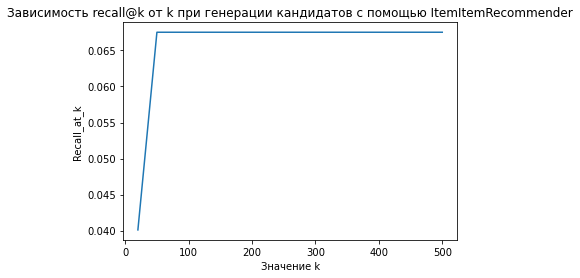

In [183]:
plt.plot(k, recall_result)
plt.xlabel('Значение k')
plt.ylabel('Recall_at_k')
plt.title('Зависимость recall@k от k при генерации кандидатов с помощью ItemItemRecommender')
plt.show()

Значение k=50 в данном случае является оптимальным, так как далее показатель recall уже не растет.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [185]:
# your_code
%conda install lightgbm

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.6.15  |       h033912b_0         149 KB  conda-forge
    openssl-1.1.1q             |       hfe4f2af_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.0 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge/label/cf202003::ca-certif~ --> conda-forge::ca-certificates-2022.6.15-h033912b_0
  openssl                                 1.1.1o-hfe4f2af_0 --> 1.1.1q-hfe4f2af_0



ca-certificates-2022 | 149 KB    | ##################################### | 100% 
openssl-1.1.1q       | 1.9 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying 

In [186]:
# Модель второго уровня
from lightgbm import LGBMClassifier

In [311]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [312]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[879194, 6442443, 1105426, 944588, 928263, 835..."
1,2021,"[950935, 1119454, 835578, 863762, 965009, 1019..."


In [313]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,879194,1
0,2070,6442443,1
0,2070,1105426,1
0,2070,944588,1


In [314]:
users_lvl_2.shape[0]

107200

In [315]:
users_lvl_2['user_id'].nunique()

2144

In [316]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [317]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,879194,0.0
1,2070,6442443,0.0


In [318]:
targets_lvl_2['target'].value_counts(normalize=True)

0.0    0.893068
1.0    0.106932
Name: target, dtype: float64

In [319]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [320]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [321]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,6442443,0.0,378,GROCERY,National,BAG SNACKS,POTATO CHIPS,10 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Фичи user_id: - Средний чек - Средняя сумма покупки 1 товара в каждой категории - Кол-во покупок в каждой категории - Частотность покупок раз/месяц - Долю покупок в выходные - Долю покупок утром/днем/вечером

Фичи item_id: - Кол-во покупок в неделю - Среднее ол-во покупок 1 товара в категории в неделю - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю) - Цена (Можно посчитать из retil_train.csv) - Цена / Средняя цена товара в категории

Фичи пары user_id - item_id - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id) - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю) - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

In [322]:
data_train_lvl_2.head(2) # отсюда возьмем данные для генерации фичей

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [323]:
data_train_lvl_2['user_id'].nunique()

2154

In [324]:
data_train_lvl_2['item_id'].nunique()

27649

In [325]:
# общий чек каждого юзера
data_train_lvl_2.groupby('user_id')['sales_value'].sum()

user_id
1       341.78
2       190.29
4       119.39
6       329.00
7       187.65
         ...  
2496    346.86
2497    560.65
2498    184.34
2499    246.26
2500    417.00
Name: sales_value, Length: 2154, dtype: float64

In [326]:
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2.groupby('user_id')['sales_value'].sum().rename('total_sales_value'), on='user_id', how='left')

In [327]:
# среднее количество товаров в корзине юзера за одну покупку
data_train_lvl_2.groupby('user_id')['quantity'].sum()/data_train_lvl_2.basket_id.count()

user_id
1       0.000872
2       0.000495
4       0.000224
6       0.000831
7       0.000684
          ...   
2496    0.000984
2497    0.028949
2498    0.000407
2499    0.000554
2500    0.247432
Name: quantity, Length: 2154, dtype: float64

In [328]:
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2.groupby(by='user_id').agg('quantity').sum().rename('user_quant_per_basket')/data_train_lvl_2.basket_id.nunique(), how='left',on='user_id')                   

In [329]:
# частота встречаемости товара в корзине
data_train_lvl_2.groupby('item_id')['quantity'].sum()/data_train_lvl_2.basket_id.nunique()

item_id
28116       0.000057
28117       0.000057
28143       0.000057
28186       0.000057
28304       0.000057
              ...   
17381856    0.000000
17382205    0.000057
17383227    0.000057
17827644    0.000057
17829232    0.000113
Name: quantity, Length: 27649, dtype: float64

In [330]:
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2.groupby(by='item_id').agg('quantity').sum().rename('item_quant_per_basket')/data_train_lvl_2.basket_id.nunique(), how='left',on='item_id')        


In [331]:
# сумма покупок каждого товара
data_train_lvl_2.groupby('item_id')['sales_value'].sum()

item_id
28116        0.33
28117        0.34
28143        0.33
28186        0.79
28304        0.53
            ...  
17381856     0.00
17382205     7.99
17383227     4.49
17827644     2.50
17829232    11.98
Name: sales_value, Length: 27649, dtype: float64

In [332]:
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2.groupby('item_id')['sales_value'].sum().rename('total_items_value_sum'),on='item_id', how='left')


In [333]:
# среднее количество покупок в неделю
data_train_lvl_2.groupby('user_id')['quantity'].sum()/data_train_lvl_2.week_no.nunique()

user_id
1         24.666667
2         14.000000
4          6.333333
6         23.500000
7         19.333333
           ...     
2496      27.833333
2497     818.833333
2498      11.500000
2499      15.666667
2500    6998.666667
Name: quantity, Length: 2154, dtype: float64

In [334]:
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2.groupby(by='user_id').agg('quantity').sum().rename('user_quant_per_week')/data_train_lvl_2.week_no.nunique(), how='left',on='user_id')


In [353]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,total_sales_value,user_quant_per_basket,item_quant_per_basket,total_items_value_sum,user_quant_per_week
0,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,617.29,0.99304,NaN,NaN,2925.0
1,2070,6442443,0.0,378,GROCERY,National,BAG SNACKS,POTATO CHIPS,10 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,617.29,0.99304,0.00034,15.0,2925.0


In [354]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [355]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111014 entries, 0 to 111013
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   user_id                111014 non-null  int64  
 1   item_id                111014 non-null  int64  
 2   manufacturer           111014 non-null  int64  
 3   department             111014 non-null  object 
 4   brand                  111014 non-null  object 
 5   commodity_desc         111014 non-null  object 
 6   sub_commodity_desc     111014 non-null  object 
 7   curr_size_of_product   111014 non-null  object 
 8   age_desc               41961 non-null   object 
 9   marital_status_code    41961 non-null   object 
 10  income_desc            41961 non-null   object 
 11  homeowner_desc         41961 non-null   object 
 12  hh_comp_desc           41961 non-null   object 
 13  household_size_desc    41961 non-null   object 
 14  kid_category_desc      41961 non-nul

In [356]:
cat_feats = X_train.columns[2:15].tolist()
cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [357]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [400]:
lgb = LGBMClassifier(objective='binary', 
                     max_depth=10, 
                     n_estimators=200,
                     learning_rate=0.01,
                     categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [401]:
train_preds[:, 1]

array([0.01869234, 0.07978151, 0.09485082, ..., 0.02335728, 0.02176723,
       0.02180513])

In [402]:
df_ranker_predict = targets_lvl_2.copy()
df_ranker_predict.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,total_sales_value,user_quant_per_basket,item_quant_per_basket,total_items_value_sum,user_quant_per_week
0,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,617.29,0.99304,NaN,NaN,2925.0
1,2070,6442443,0.0,378,GROCERY,National,BAG SNACKS,POTATO CHIPS,10 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,617.29,0.99304,0.00034,15.0,2925.0


In [411]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
df_ranker_predict.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,total_sales_value,user_quant_per_basket,item_quant_per_basket,total_items_value_sum,user_quant_per_week,proba_item_purchase
0,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,...,Unknown,Unknown,1,None/Unknown,617.29,0.99304,NaN,NaN,2925.0,0.018692
1,2070,6442443,0.0,378,GROCERY,National,BAG SNACKS,POTATO CHIPS,10 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,617.29,0.99304,0.00034,15.0,2925.0,0.079782


In [412]:
result_val_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_val_lvl_2.columns=['user_id', 'actual']
result_val_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [413]:
%%time
k = 50
result_val_lvl_2['candidates_own'] = result_val_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))


CPU times: user 3.79 s, sys: 29.1 ms, total: 3.81 s
Wall time: 3.85 s


In [414]:
def precision_calc(data, top_k):
    for col in data.columns[2:]:
        yield col, data.apply(lambda row: precision_at_k(row[col], row['actual'], k=top_k), axis=1).mean()

In [415]:
top_k_precision = 5
sorted(precision_calc(result_val_lvl_2, top_k_precision), key=lambda x: x[1], reverse=True)

[('candidates_own', 0.13786982248520593)]

In [416]:
sorted(precision_calc(result_lvl_1, top_k_precision), key=lambda x: x[1], reverse=True)

[('candidates_own', 0.178638059701491),
 ('candidates_als', 0.13143656716417773),
 ('candidates_sim_item', 0.05559701492537353),
 ('candidates_sim_user', 0.01473880597014922)]

In [417]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()


In [418]:
result_val_lvl_2['reranked_own_rec'] = result_val_lvl_2['user_id'].apply(lambda user_id: rerank(user_id))

In [419]:
top_k_precision = 5
sorted(precision_calc(result_val_lvl_2, top_k_precision), key=lambda x: x[1], reverse=True)

[('candidates_own', 0.13786982248520593),
 ('reranked_own_rec', 0.12697747511786184)]

Precision почему-то не вырос, возможно, стоит лучше подобрать параметры модели lgb или добавить еще фичей.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 